# Preprocessing

Processing pipeline:
 - receives contract
 - extracts list of global variable names
 - extracts list of modifier names
 - extracts list of function source code
 - creates tokenized list of functions

In [ ]:
# imports for lexer, data manipulation, and smart contract dataset
import pygments.lexers
import numpy as np
from gensim.models import Word2Vec

import warnings
warnings.simplefilter('ignore')

import sys
sys.path.append('./contracts')
sys.path.append('./contractLabels')
import contracts
import contractLabels

### Extract Global Variables

In [2]:
# checks if keyword is for variable declaration (helper for global variable parser)
def isType(word):
    keywords = ['address', 'bool', 'byte', 'bytes', 'int', 'string', 'uint', 'mapping']
    for kw in keywords:
        if kw in word:
            return True
    return False

In [3]:
# takes in full contract and pulls out names of global variables (with reasonable accuracy)
def getGlobalVariables(contract):
    lexer = pygments.lexers.get_lexer_by_name('Solidity')
    tokens = list(pygments.lex(contract, lexer))
    globalVarList = []
    openBracketsCount = 0
    openParenthesisCount = 0
    i = 0
    while i < len(tokens):
        if str(tokens[i][0]) == 'Token.Text.Whitespace' or str(tokens[i][0]) == 'Token.Comment.Single': None
        elif(tokens[i][1] == '{'): openBracketsCount += 1
        elif(tokens[i][1] == '}'): openBracketsCount -= 1
        elif(tokens[i][1] == '('): openParenthesisCount += 1
        elif(tokens[i][1] == ')'): openParenthesisCount -= 1
        elif(str(tokens[i][0]) == 'Token.Keyword.Type' and isType(tokens[i][1]) and openBracketsCount == 1 and openParenthesisCount == 0):
            index = 0
            potentialGlobal = ""
            include = True
            while True:
                if(tokens[i+index][1] == "constant"): 
                    include = False
                if(tokens[i+index][1] == ';'):
                    if include:
                        globalVarList.append(potentialGlobal)
                    break
                if(tokens[i+index][0] == pygments.token.Name.Variable or tokens[i+index][0] == pygments.token.Text):
                    potentialGlobal = tokens[i+index][1]
                    
                index += 1
            i += (index-1)
        i += 1
        
    return globalVarList

### Extract Modifiers

In [4]:
# extracts names of modifiers (function guards) for tokenization process
def getModifiers(contract):
    lexer = pygments.lexers.get_lexer_by_name('Solidity')
    tokens = list(pygments.lex(contract, lexer))
    filteredTokens = []
    for token in tokens:
        if str(token[0]) != 'Token.Text.Whitespace':
            filteredTokens.append(token)
            
    modifierNameList = []
    openBracketsCount = 0
    openParenthesisCount = 0
    i = 0
    while i < len(filteredTokens):
        if(str(filteredTokens[i][0]) == 'Token.Keyword.Type' and str(filteredTokens[i][1]) == 'modifier'):
            modifierNameList.append(filteredTokens[i+1][1])
        
        i += 1
        
    return modifierNameList

### Extract Function Source Code

In [5]:
# given contract source code, extracts a list of basic tokens for individual functions
def getFunctions(contract):
    lexer = pygments.lexers.get_lexer_by_name('Solidity')
    tokens = list(pygments.lex(contract, lexer))
    functionList = []
    i = 0
    while i < len(tokens):
        if str(tokens[i][0]) == "Token.Keyword.Type" and tokens[i][1] == 'function':
            currFunctionNum = len(functionList)
            functionList.append([tokens[i]])
            i += 1
            
            oneLiner = False
            while tokens[i][1] != '{':
                # the one-liner case
                if str(tokens[i][1]) == ';':
                    i += 1
                    oneLiner = True
                    break
                if str(tokens[i][0]) != 'Token.Text.Whitespace' and str(tokens[i][0]) != 'Token.Comment.Single':
                    functionList[currFunctionNum].append(tokens[i])
                i += 1
                
            functionList[currFunctionNum].append(tokens[i])
            openBracketsCount = 1
            i += 1
            
            while openBracketsCount > 0:
                if(tokens[i][1] == '{'): openBracketsCount += 1
                elif(tokens[i][1] == '}'): openBracketsCount -= 1
                
                if str(tokens[i][0]) != 'Token.Text.Whitespace' and str(tokens[i][0]) != 'Token.Comment.Single':
                    functionList[currFunctionNum].append(tokens[i])
                i += 1
        else:
            i += 1
    return functionList

### Tokenize Functions

In [6]:
# given a function's basic tokenization and a list of modifier and global variable names, fully tokenize function
def tokenize(parsedFunction, globalVariablesList, modifierNameList):
    txKeywords = ['call', 'transfer', 'send']
    tokenList = []
    for tup in parsedFunction:
        if tokenList and tokenList[-1] == "function":
            tokenList.append("Token.FunctionName")
        elif str(tup[1]) in txKeywords:
            tokenList.append("Token.TxWord")
        elif tup[1] in globalVariablesList:
            tokenList.append("Token.GlobalVariable")
        elif tup[1] in modifierNameList:
            tokenList.append("Token.ModifierName")
        elif tup[1].startswith("\""):
            tokenList.append("Token.String")
        elif str(tup[0]) == 'Token.Name.Variable' or str(tup[0]) == 'Token.Text':
            tokenList.append("Token.LocalVariable")
        elif str(tup[0]) != 'Token.Text.Whitespace' and str(tup[0]) != 'Token.Comment.Single':
            tokenList.append(tup[1])
    return tokenList

In [7]:
# given contract source code, extracts a list of tokenized functions
def tokenizeContractFunctions(contract):
    globalVariablesList = getGlobalVariables(contract)
    modifierNameList = getModifiers(contract)
    functionList = getFunctions(contract)
    
    tokenizedFunctionList = []
    for function in functionList:
        tokenizedFunction = tokenize(function, globalVariablesList, modifierNameList)
        tokenizedFunctionList.append(tokenizedFunction)
    
    return tokenizedFunctionList

### Create Matching Lists of Functions and Corresponding Labels

In [8]:
# given contract source code and labels, extracts tokenized functions and corresponding function labels
def returnData(contracts, contractLabels):
    functions = []
    labels = []
    for i in range(len(contracts)):
        tokenizedFunctions = tokenizeContractFunctions(contracts[i])
        functions.extend(tokenizedFunctions)
        labels.extend(contractLabels[i])
    
    return [functions, labels]

### Create Embeddings for Tokens

In [9]:
# creates Word2Vec mapping from token to vector
def get_w2v_mapping(tokenizedFunctionsDf, token_dim):
    w2v = Word2Vec(tokenizedFunctionsDf, min_count=1, vector_size=token_dim, workers=3, window=3, sg=1)
    return w2v

In [10]:
# given list of tokenized functions, convert into list of list of embeddings
def vectorize_functions(tokenized_functions, w2v_mapping):
    embedding_list = []
    for i in range(len(tokenized_functions)):
        embedding = []
        for token in tokenized_functions[i]:
            embedding.append(w2v_mapping.wv[token])
        
        embedding_list.append(embedding)
    return embedding_list

In [11]:
# given list of embeddings, add padding
def pad_embeddings(embeddings, max_length, token_dim):
    padded_embeddings = []
    for embedding in embeddings:
        zero_padding_cnt = max_length - len(embedding)
        pad = np.zeros((1, token_dim))
        for i in range(zero_padding_cnt):
            embedding = np.concatenate((embedding, pad), axis=0)
        padded_embeddings.append(embedding)
    return padded_embeddings

In [12]:
# compiles Word2Vec mapping, creates embedded function representations, and applies padding
def getFunctionEmbeddings(tokenizedFunctions, max_length, token_dim):
    w2v_mapping = get_w2v_mapping(tokenizedFunctions, token_dim)
    vectorized_fns = vectorize_functions(tokenizedFunctions, w2v_mapping)
    padded_embeddings = pad_embeddings(vectorized_fns, max_length, token_dim)
    return [w2v_mapping, padded_embeddings]

In [ ]:
length = 500
token_dim = 15

[functions, labels] = returnData(contracts.contracts, contractLabels.labels)
[w2v_mapping, fn_embeddings] = getFunctionEmbeddings(functions, length, token_dim)
fn_embeddings = np.array(fn_embeddings)
print("X shape: ", fn_embeddings.shape)

X shape:  (227, 500, 15)


### Token Visualization

In [15]:
# imports for data representation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# given a w2v embedding, plot a t-distributed stochastic neighbor embedding
def tsne_plot(model):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)

    tokens = np.array(tokens)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

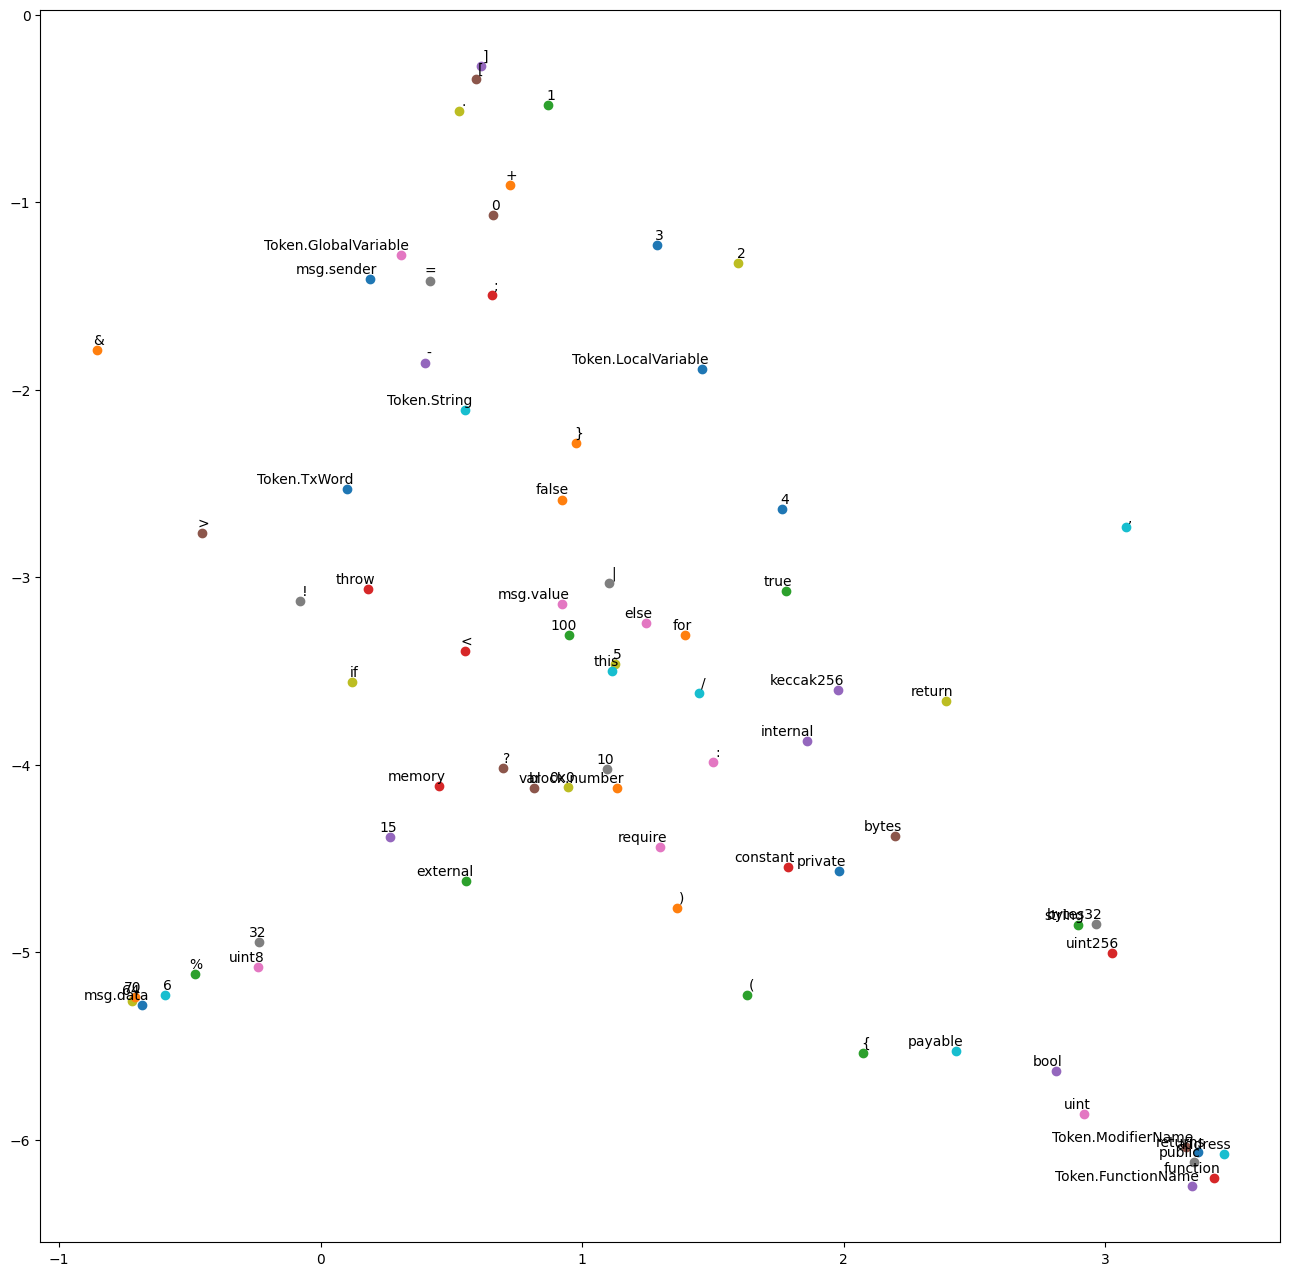

In [ ]:
[functions, labels] = returnData(contracts.contracts, contractLabels.labels)
[w2v_mapping, fn_embeddings] = getFunctionEmbeddings(functions, length, token_dim)

tsne_plot(w2v_mapping)

# Data Preparation

In [ ]:
from sklearn.model_selection import train_test_split

# compile formatted data and create splits
[functions, labels] = returnData(contracts.contracts, contractLabels.labels)
[w2v_mapping, X_train_emb] = getFunctionEmbeddings(functions, 500, 15)

X = np.array(X_train_emb)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=46, shuffle=True, random_state=42)

In [18]:
print(X_train.shape)
print(y_train.shape)

(181, 500, 15)
(181,)


In [19]:
print(X_test.shape)
print(y_test.shape)

(46, 500, 15)
(46,)


In [20]:
import json

x = X_test[0]
print(f"Shape of first sample: {x.shape}")  # should print (500, 15)

x = dict(input_data = [x.tolist()])
data = {'input_data': [x]}

# save first sample as input for proof witness
with open("input.json", "w") as f:
    json.dump(data, f)

Shape of first sample: (500, 15)


# Twolayer CNN with Dropout

In [ ]:
# imports for torch, data manipulation, and model evaluation 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.utils import class_weight
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import os
import json

In [114]:
class TwoLayerDropCNN(nn.Module):
    def __init__(self, conv1_out_channels=64, conv2_out_channels=64, dropout_rate=0.4, kernel_size=7):
        super(TwoLayerDropCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=15, out_channels=conv1_out_channels, kernel_size=kernel_size, stride=1)
        self.conv2 = nn.Conv1d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=kernel_size, stride=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.linear = nn.Linear(conv2_out_channels,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # permute x from (batch, 500, 15) to (batch, 15, 500) for convolution
        x = x.permute(0, 2, 1)
    
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.pool(x)
        x = x.squeeze(-1)
        x = self.dropout(x) 
        x = self.linear(x)
        
        x = self.sigmoid(x)
        return x

In [115]:
# compute class weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_test), y=y_train)
weights = dict(enumerate(weights))

# convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# create dataloader
batch_size = 30
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = TwoLayerDropCNN()  
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
loss_fn = nn.BCELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

class_weights = torch.tensor(list(weights.values()), dtype=torch.float32)
train_losses = []
test_losses = []
epochs = 150

# training step
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        # forward pass
        y_pred = model(X_batch)
        
        # compute per-sample loss
        loss = loss_fn(y_pred, y_batch)
        
        # apply class weights
        sample_weights = class_weights[y_batch.long().view(-1)].view(-1, 1).to(device)
        weighted_loss = (loss * sample_weights).mean()
        
        weighted_loss.backward()
        optimizer.step()
        
        train_loss += weighted_loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # evaluation step
    model.eval()
    test_loss_epoch = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # forward pass
            y_pred = model(X_batch)

            # compute per-sample loss
            loss = loss_fn(y_pred, y_batch)

            # apply class weights
            sample_weights = class_weights[y_batch.long().view(-1)].view(-1, 1).to(device)
            weighted_loss = (loss * sample_weights).mean()

            test_loss_epoch += weighted_loss.item()
    
    avg_test_loss = test_loss_epoch / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    
# accuracy and f1 score calculation
model.eval()
correct = 0
total = 0
all_y_true = []
all_y_scores = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        predicted_labels = (y_pred > 0.5).float()
        
        correct += (predicted_labels == y_batch).sum().item()
        total += y_batch.size(0)
        
        all_y_scores.extend(y_pred.cpu().numpy().ravel())
        all_y_true.extend(y_batch.cpu().numpy().ravel())
    
accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

all_y_pred = [1 if score > 0.5 else 0 for score in all_y_scores]
f1 = f1_score(all_y_true, all_y_pred)
print(f"F1 Score: {f1:.4f}")

Epoch 1/150, Train Loss: 0.8015, Test Loss: 0.7375
Epoch 2/150, Train Loss: 0.6540, Test Loss: 0.7290
Epoch 3/150, Train Loss: 0.6469, Test Loss: 0.7237
Epoch 4/150, Train Loss: 0.6329, Test Loss: 0.7241
Epoch 5/150, Train Loss: 0.6099, Test Loss: 0.7069
Epoch 6/150, Train Loss: 0.5999, Test Loss: 0.6939
Epoch 7/150, Train Loss: 0.5864, Test Loss: 0.6564
Epoch 8/150, Train Loss: 0.5641, Test Loss: 0.6191
Epoch 9/150, Train Loss: 0.6872, Test Loss: 0.5782
Epoch 10/150, Train Loss: 0.5752, Test Loss: 0.5855
Epoch 11/150, Train Loss: 0.6040, Test Loss: 0.5258
Epoch 12/150, Train Loss: 0.4810, Test Loss: 0.5376
Epoch 13/150, Train Loss: 0.5218, Test Loss: 0.4921
Epoch 14/150, Train Loss: 0.4923, Test Loss: 0.4451
Epoch 15/150, Train Loss: 0.4849, Test Loss: 0.4537
Epoch 16/150, Train Loss: 0.5414, Test Loss: 0.4217
Epoch 17/150, Train Loss: 0.4688, Test Loss: 0.4386
Epoch 18/150, Train Loss: 0.6297, Test Loss: 0.3812
Epoch 19/150, Train Loss: 0.4468, Test Loss: 0.3925
Epoch 20/150, Train L

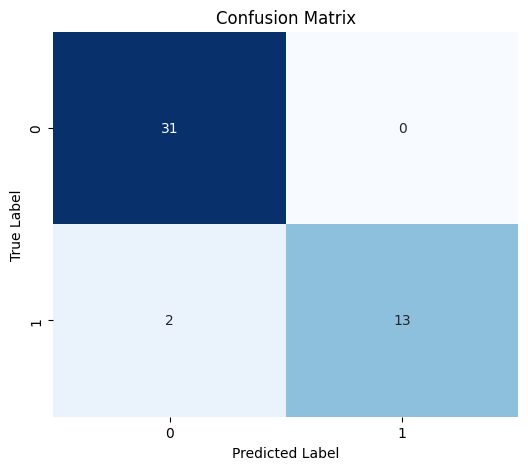

In [116]:
# plot confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


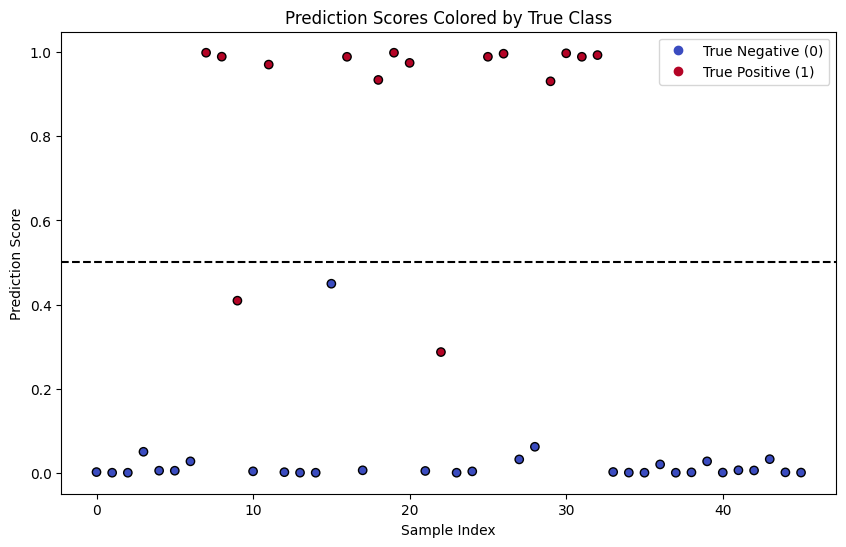

In [117]:
# plot prediction scores
plt.figure(figsize=(10, 6))
scatter = plt.scatter(range(len(all_y_scores)), all_y_scores, c=all_y_true, cmap='coolwarm', edgecolor='k')
plt.axhline(0.5, color='black', linestyle='--', label='Decision Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Score')
plt.title('Prediction Scores Colored by True Class')
handles, _ = scatter.legend_elements()
custom_labels = ['True Negative (0)', 'True Positive (1)']
plt.legend(handles, custom_labels)
plt.show()


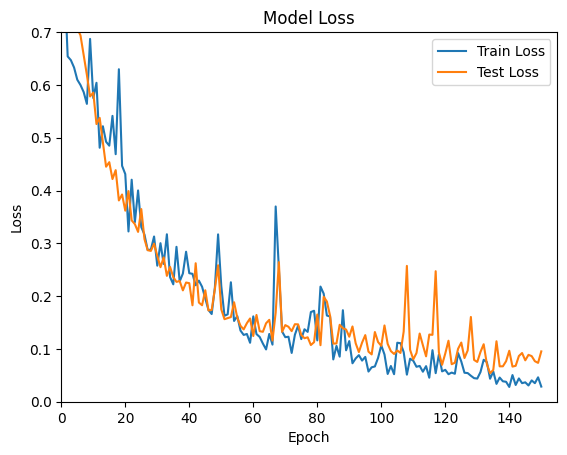

In [118]:
# plot model loss curve
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim([0.0, 155.0])
plt.ylim([0.0, 0.7])
plt.legend()
plt.show()

### Export the Model to onnx

In [97]:
dummy_input = torch.randn(1, 500, 15)
onnx_path = "network.onnx"
torch.onnx.export(model, dummy_input, onnx_path, opset_version=10, input_names=['input'])

print(f"Model exported to {onnx_path}")

Model exported to network.onnx


### Export Calibration Data

In [98]:
num_data_points = 8

data_points = []
for i, (data_point, _) in enumerate(train_dataset):
    if i >= num_data_points:
        break
    data_points.append(data_point)
train_data_batch = torch.stack(data_points)

# convert the tensor to a flattened list
x = train_data_batch.cpu().detach().numpy().reshape([-1]).tolist()

# prepare the data dictionary for ezkl
data = {"input_data": [x]}

cal_path = os.path.join('calibration.json')

# serialize the data into json
with open(cal_path, 'w') as f:
    json.dump(data, f)
    
print(f"Calibration data saved to {cal_path}")


Calibration data saved to calibration.json


# EZKL!

In [ ]:
import ezkl

# define paths
srs_path = "kzg.srs"
model_path = "network.onnx"
settings_path = "settings.json"
compiled_model_path = "network.compiled"
calibration_path = "calibration.json"
input_path = "input.json"
witness_path = "witness.json"
pk_path = "pk.key"
vk_path = "vk.key"
proof_path = "proof.json"

### Setup Phase

In [ ]:
# generate settings for the given model
res = ezkl.gen_settings(model_path, settings_path)
assert res == True

[*] [2025-02-26 17:31:15:046, ezkl] - succeeded


In [ ]:
# calibrate settings using model training data 
res = ezkl.calibrate_settings(calibration_path, model_path, settings_path, "resources")
assert res == True

[*] [2025-02-26 17:32:14:223, ezkl::execute] - num calibration batches: 8
[*] [2025-02-26 17:32:14:224, tract_linalg::x86_64_fma] - qmmm_i32: x86_64/avx2 activated
[*] [2025-02-26 17:32:14:224, tract_linalg::x86_64_fma] - found f16c, added fake-f16 and q40-able kernels
[*] [2025-02-26 17:32:14:224, tract_linalg::x86_64_fma] - mmm_f32, mmv_f32, sigmoid_f32, tanh_f32: x86_64/fma activated
[*] [2025-02-26 17:32:14:224, tract_linalg::x86_64_fma] - mmm_f32, mmv_f32: x86_64/avx512f activated
[W] [2025-02-26 17:38:24:995, ezkl::execute] - 
 |  
 |   <------------- Numerical Fidelity Report (input_scale: 13, param_scale: 13, scale_input_multiplier: 1) ------------->
 |  
 |  +------------------+----------------+----------------+-----------------+----------------+------------------+----------------+-------------------+--------------------+--------------------+------------------------+
 |  | mean_error       | median_error   | max_error      | min_error       | mean_abs_error | median_abs_error 

In [ ]:
# get the structured reference string to be used for KZG commitments
res = await ezkl.get_srs(settings_path, srs_path=srs_path)
assert res == True

In [ ]:
# convert the model into compiled circuit format
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

[*] [2025-02-26 17:46:13:291, ezkl] - succeeded


In [ ]:
# generate verification key and proving key
res = ezkl.setup(compiled_model_path, vk_path, pk_path, srs_path)
assert res == True

[*] [2025-02-26 17:48:07:480, ezkl::graph::model] - model layout...
[*] [2025-02-26 17:48:07:481, ezkl::circuit::table] - Generating lookup table and saving to cache: "/data/.ezkl/cache/sigmoid_8192_-347978_33206445"
[*] [2025-02-26 17:48:18:493, ezkl::circuit::table] - Loading range check table from cache: "/data/.ezkl/cache/rangecheck_-1_1"
[*] [2025-02-26 17:48:18:586, ezkl::circuit::table] - Loading range check table from cache: "/data/.ezkl/cache/rangecheck_0_16383"
[*] [2025-02-26 17:52:27:058, ezkl::pfsys] - VK took 281.302
[*] [2025-02-26 17:52:33:976, ezkl::graph::model] - model layout...
[*] [2025-02-26 17:52:33:977, ezkl::circuit::table] - Loading lookup table from cache: "/data/.ezkl/cache/sigmoid_8192_-347978_33206445"
[*] [2025-02-26 17:52:42:959, ezkl::circuit::table] - Loading range check table from cache: "/data/.ezkl/cache/rangecheck_-1_1"
[*] [2025-02-26 17:52:43:558, ezkl::circuit::table] - Loading range check table from cache: "/data/.ezkl/cache/rangecheck_0_16383"

### Proving Phase

In [ ]:
res = ezkl.gen_witness(input_path, compiled_model_path, witness_path, vk_path, srs_path)
assert res == True

In [ ]:
res = ezkl.prove(witness_path, compiled_model_path, pk_path, proof_path, "for-aggr", srs_path)
assert res == True

### Verification Phase

In [ ]:
res = ezkl.verify(proof_path, settings_path, vk_path, srs_path, False)
assert res == True